In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from warnings import filterwarnings
filterwarnings('ignore')

<h4>Try to read in the data...</h4>

In [3]:
df = pd.read_csv('data/dylan_data/play_by_play_2010_11.csv', encoding='latin1')

In [55]:
df[df.event_type == 'STOP']

,xg,event_id,event_type,event,secondary_type,event_team,event_team_type,description,period,period_seconds,...,home_abbreviation,home_division_name,home_conference_name,home_id,away_name,away_abbreviation,away_division_name,away_conference_name,away_id,venue_id
28,NaN,2.010020e+13,STOP,Stoppage,NaN,NaN,NaN,Icing,1,147,...,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0
46,NaN,2.010020e+13,STOP,Stoppage,NaN,NaN,NaN,Puck in Netting,1,267,...,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0
79,NaN,2.010020e+13,STOP,Stoppage,NaN,NaN,NaN,Puck in Benches,1,408,...,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0
96,NaN,2.010020e+13,STOP,Stoppage,NaN,NaN,NaN,Puck in Crowd,1,523,...,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0
145,NaN,2.010020e+13,STOP,Stoppage,NaN,NaN,NaN,Goalie Stopped,1,752,...,TOR,Northeast,Eastern,10,Montréal Canadiens,MTL,Northeast,Eastern,8,5015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816274,NaN,2.010030e+13,STOP,Stoppage,NaN,NaN,NaN,Icing,3,679,...,VAN,Northwest,Western,23,Boston Bruins,BOS,Northeast,Eastern,6,5073.0
816309,NaN,2.010030e+13,STOP,Stoppage,NaN,NaN,NaN,Goalie Stopped,3,849,...,VAN,Northwest,Western,23,Boston Bruins,BOS,Northeast,Eastern,6,5073.0
816322,NaN,2.010030e+13,STOP,Stoppage,NaN,NaN,NaN,Offside,3,915,...,VAN,Northwest,Western,23,Boston Bruins,BOS,Northeast,Eastern,6,5073.0
816354,NaN,2.010030e+13,STOP,Stoppage,NaN,NaN,NaN,Offside,3,1096,...,VAN,Northwest,Western,23,Boston Bruins,BOS,Northeast,Eastern,6,5073.0


In [54]:
df.game_seconds_remaining

0         3600
1         3600
2         3600
3         3600
4         3585
          ... 
816373      14
816374       0
816375       0
816376       0
816377       0
Name: game_seconds_remaining, Length: 816378, dtype: int64

In [91]:
# Group by game_id, and count the number of each event time.
# Then, unstack the result to make the event types into columns.

shot_stuff = df.groupby(['game_id', 'event_team', 'event_type']).size().unstack()
shot_stuff

event_type                      BLOCKED_SHOT  CHANGE  FACEOFF  GIVEAWAY  GOAL  \
game_id    event_team                                                           
2010020001 Montréal Canadiens           22.0   185.0     23.0       7.0   2.0   
           Toronto Maple Leafs          21.0   158.0     20.0      16.0   3.0   
2010020002 Philadelphia Flyers          14.0   147.0     22.0       9.0   3.0   
           Pittsburgh Penguins          16.0   144.0     34.0      11.0   2.0   
2010020003 Carolina Hurricanes          19.0   208.0     33.0      11.0   4.0   
...                                      ...     ...      ...       ...   ...   
2010030415 Vancouver Canucks            19.0   222.0     34.0      12.0   1.0   
2010030416 Boston Bruins                14.0   164.0     46.0       NaN   5.0   
           Vancouver Canucks            17.0   173.0     28.0       5.0   2.0   
2010030417 Boston Bruins                14.0   266.0     29.0       8.0   4.0   
           Vancouver Canucks            15.0   193.0     26.0      11.0   NaN   

event_type                       HIT  MISSED_SHOT  PENALTY  SHOT  TAKEAWAY  
game_id    event_team                                                       
2010020001 Montréal Canadiens   34.0         15.0      5.0  26.0       7.0  
           Toronto Maple Leafs  27.0          9.0      3.0  21.0       6.0  
2010020002 Philadelphia Flyers  34.0         10.0      6.0  24.0       1.0  
           Pittsburgh Penguins  32.0         18.0      5.0  29.0       9.0  
2010020003 Carolina Hurricanes  14.0          9.0      5.0  27.0       3.0  
...                              ...          ...      ...   ...       ...  
2010030415 Vancouver Canucks    47.0         12.0      5.0  24.0      15.0  
2010030416 Boston Bruins        43.0          5.0     10.0  35.0       5.0  
           Vancouver Canucks    38.0         15.0      9.0  36.0       5.0  
2010030417 Boston Bruins        29.0          8.0      2.0  17.0       8.0  
           Vancouver Canucks    47.0         10.0      1.0  37.0      12.0  

[2580 rows x 10 columns]

In [4]:
def get_data(df, game_id):
    """
    Extracts and organizes event data for a specific game.

    Args:
    df (DataFrame): The DataFrame containing the game data.
    game_id (int): The ID of the game to retrieve data for.

    Returns:
    tuple: A tuple containing two DataFrames, one for home team events and one for away team events.
    """

    # Filter the DataFrame to get data for the specified game and drop rows with NaN values in event_team_type
    game1 = df[df.game_id == game_id] 
    game1 = game1.dropna(subset=['event_team_type'])

    # Get unique event types (excluding CHANGE)
    event_types = game1.event_type.unique()
    event_types = np.delete(event_types, np.where(event_types == 'CHANGE'))
    event_types = np.append(event_types, ['TIME_REMAINING', 'HOME', 'WIN', 'TEAM', 'GAME_ID', 'CORSI', 'FENWICK'])

    # Create dictionaries to store event counts for home and away teams
    final_dict = {f'HOME_{event}': 0 for event in event_types}
    away_dict = {f'AWAY_{event}': 0 for event in event_types}
    final_dict.update(away_dict)

    # Create DataFrames to store event data for home and away teams
    final_df = False

    # Iterate through the events in the game and count them
    for _, row in game1.iterrows():
        # Skip events with NaN event_team_type or events of type CHANGE
        if pd.isnull(row['event_team_type']) or row['event_type'] == 'CHANGE':
            continue
        
        # Determine if the event belongs to the home or away team and update counts accordingly
        if row['event_team_type'] == 'home':
            final_dict[f"HOME_{row['event_type']}"] += 1
            final_dict['TIME_REMAINING'] = row['game_seconds_remaining']
            final_dict['HOME_HOME'] = 1
            final_dict['WIN'] = 1 if row['home_final'] > row['away_final'] else 0
            final_dict['HOME_TEAM'] = row['team_encoded']
            final_dict['GAME_ID'] = game_id

            # Get the Corsi and Fenwick for the home team
            if row['strength_code'] == "EV":
                final_dict['HOME_CORSI'] = calculate_corsi(final_dict, 'HOME')
                final_dict['HOME_FENWICK'] = calculate_fenwick(final_dict, 'HOME')
                final_dict['HOME_CORSI_FOR'] = calculate_corsi_for(final_dict['HOME_CORSI'], final_dict['AWAY_CORSI'])
                final_dict['HOME_FENWICK_FOR'] = calculate_fenwick_for(final_dict['HOME_FENWICK'], final_dict['AWAY_FENWICK'])
            
            # home_df = home_df.append(home_dict, ignore_index=True)
        else:
            final_dict[f"AWAY_{row['event_type']}"] += 1
            final_dict['TIME_REMAINING'] = row['game_seconds_remaining']
            final_dict['AWAY_HOME'] = 0
            final_dict['WIN'] = 0 if row['home_final'] < row['away_final'] else 1
            final_dict['AWAY_TEAM'] = row['team_encoded']
            final_dict['GAME_ID'] = game_id
            
            # Get the Corsi and Fenwick for the away team
            if row['strength_code'] == "EV":
                final_dict['AWAY_CORSI'] = calculate_corsi(final_dict, "AWAY")
                final_dict['AWAY_FENWICK'] = calculate_fenwick(final_dict, "AWAY")
                final_dict['AWAY_CORSI_FOR'] = calculate_corsi_for(final_dict['AWAY_CORSI'], final_dict['HOME_CORSI'])
                final_dict['AWAY_FENWICK_FOR'] = calculate_fenwick_for(final_dict['AWAY_FENWICK'], final_dict['HOME_FENWICK'])
                
            # away_df = away_df.append(away_dict, ignore_index=True)
        if type(final_df) is bool:
            # print(final_dict)
            final_df = pd.DataFrame(final_dict, index=[0])
        else:
            final_df = final_df.append(final_dict, ignore_index=True)
        
    return final_df



def get_label_encoder(teams):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(teams)
    return le


def calculate_corsi(team_dict, h_or_a):
    """
    Calculates the Corsi for a team.

    Args:
    team_dict (dict): A dictionary containing event counts for a team.

    Returns:
    int: The Corsi for the team.
    """
    return team_dict[f'{h_or_a}_SHOT'] + team_dict[f'{h_or_a}_MISSED_SHOT'] + team_dict[f'{h_or_a}_BLOCKED_SHOT']


def calculate_fenwick(team_dict, h_or_a):
    """
    Calculates the Fenwick for a team.

    Args:
    team_dict (dict): A dictionary containing event counts for a team.

    Returns:
    int: The Fenwick for the team.
    """
    return team_dict[f'{h_or_a}_SHOT'] + team_dict[f'{h_or_a}_MISSED_SHOT']


def calculate_corsi_for(team_corsi, opp_corsi):
    """
    Calculates the Corsi For Percentage for a team.

    Args:
    team_corsi (int): The Corsi for the team.
    opp_corsi (int): The Corsi for the opposing team.

    Returns:
    float: The Corsi For Percentage for the team.
    """
    # Check if the denominator is zero to avoid division by zero
    if team_corsi + opp_corsi == 0:
        return 0
    
    return team_corsi / (team_corsi + opp_corsi)


def calculate_fenwick_for(team_fenwick, opp_fenwick):
    """
    Calculates the Fenwick For Percentage for a team.

    Args:
    team_fenwick (int): The Fenwick for the team.
    opp_fenwick (int): The Fenwick for the opposing team.

    Returns:
    float: The Fenwick For Percentage for the team.
    """
    # Check if the denominator is zero to avoid division by zero
    if team_fenwick + opp_fenwick == 0:
        return 0
    
    return team_fenwick / (team_fenwick + opp_fenwick)

def merge_home_away(home_df, away_df):
     # change the names in the home_df to be HOME_[current column name] and same for away_df
     home_df.columns = ['HOME_' + col for col in home_df.columns]
     away_df.columns = ['AWAY_' + col for col in away_df.columns]
     # change TIME_REMAINING, WIN, GAME_ID to be the same in both dataframes
     home_df = home_df.rename(columns={'HOME_TIME_REMAINING': 'TIME_REMAINING', 'HOME_WIN': 'WIN', 'HOME_GAME_ID': 'GAME_ID'})
     away_df = away_df.rename(columns={'AWAY_TIME_REMAINING': 'TIME_REMAINING', 'AWAY_WIN': 'WIN', 'AWAY_GAME_ID': 'GAME_ID'})

     full = pd.merge(home_df, away_df, on=['TIME_REMAINING', 'WIN', 'GAME_ID'], how='outer')

     # if home_df has 1 in WIN column than make all the values in the WIN column 1
     if 1 in home_df.WIN.unique():
          full.WIN = 1
     elif 1 in away_df.WIN.unique():
          full.WIN = 0

     full.drop(columns=['HOME_HOME', 'AWAY_HOME'])
     full = full.sort_values(by='TIME_REMAINING')
     full.fillna(method='ffill', inplace=True)
     full.fillna(0, inplace=True)

     return full

In [40]:
def get_data_opt(df, game_id):
    """
    Extracts and organizes event data for a specific game.

    Args:
    df (DataFrame): The DataFrame containing the game data.
    game_id (int): The ID of the game to retrieve data for.

    Returns:
    tuple: A tuple containing two DataFrames, one for home team events and one for away team events.
    """

    # Filter the DataFrame to get data for the specified game and drop rows with NaN values in event_team_type
    game1 = df[df.game_id == game_id] 
    game1 = game1.dropna(subset=['event_team_type'])


    # Get unique event types (excluding CHANGE)
    event_types = game1.event_type.unique()
    event_types = np.delete(event_types, np.where(event_types == 'CHANGE'))
    event_types = np.append(event_types, ['TIME_REMAINING', 'HOME', 'WIN', 'TEAM', 'GAME_ID', 'CORSI', 'FENWICK'])

    # Create dictionaries to store event counts for home and away teams
    final_dict = {f'HOME_{event}': 0 for event in event_types}
    away_dict = {f'AWAY_{event}': 0 for event in event_types}
    final_dict.update(away_dict)

    # Create DataFrames to store event data for home and away teams
    final_df = False
    
    # Keep only the columns we need
    game1 = game1[['event_team_type', 'event_type', 'game_seconds_remaining', 'home_final', 'away_final', 'team_encoded', 'strength_code']]
    
    # Drop all 'CHANGE' events from event_type
    game1 = game1[game1.event_type != 'CHANGE']

    # Iterate through the events in the game and count them
    for team, event, sec_rem, home_score, away_score, team_num, strength  in game1.values:
        # Skip events with NaN event_team_type or events of type CHANGE
        if pd.isnull(team) or event == 'CHANGE':
            continue
        
        # Determine if the event belongs to the home or away team and update counts accordingly
        if team == 'home':
            final_dict[f"HOME_{event}"] += 1
            final_dict['TIME_REMAINING'] = sec_rem
            final_dict['HOME_HOME'] = 1
            final_dict['WIN'] = 1 if home_score > away_score else 0
            final_dict['HOME_TEAM'] = team_num
            final_dict['GAME_ID'] = game_id

            # Get the Corsi and Fenwick for the home team
            if strength == "EV":
                final_dict['HOME_CORSI'] = calculate_corsi(final_dict, 'HOME')
                final_dict['HOME_FENWICK'] = calculate_fenwick(final_dict, 'HOME')
                final_dict['HOME_CORSI_FOR'] = calculate_corsi_for(final_dict['HOME_CORSI'], final_dict['AWAY_CORSI'])
                final_dict['HOME_FENWICK_FOR'] = calculate_fenwick_for(final_dict['HOME_FENWICK'], final_dict['AWAY_FENWICK'])
            
            # home_df = home_df.append(home_dict, ignore_index=True)
        else:
            final_dict[f"AWAY_{event}"] += 1
            final_dict['TIME_REMAINING'] = sec_rem
            final_dict['AWAY_HOME'] = 0
            final_dict['WIN'] = 0 if home_score < away_score else 1
            final_dict['AWAY_TEAM'] = team_num
            final_dict['GAME_ID'] = game_id
            
            # Get the Corsi and Fenwick for the away team
            if strength == "EV":
                final_dict['AWAY_CORSI'] = calculate_corsi(final_dict, "AWAY")
                final_dict['AWAY_FENWICK'] = calculate_fenwick(final_dict, "AWAY")
                final_dict['AWAY_CORSI_FOR'] = calculate_corsi_for(final_dict['AWAY_CORSI'], final_dict['HOME_CORSI'])
                final_dict['AWAY_FENWICK_FOR'] = calculate_fenwick_for(final_dict['AWAY_FENWICK'], final_dict['HOME_FENWICK'])
                
            # away_df = away_df.append(away_dict, ignore_index=True)
        if type(final_df) is bool:
            # print(final_dict)
            final_df = pd.DataFrame(final_dict, index=[0])
        else:
            final_df = final_df.append(final_dict, ignore_index=True)
        
    return final_df

In [41]:
# Copy the dataframe
df_copy = df.copy()

# Drop NaN's from event_team_type
df_copy = df_copy.dropna(subset=['event_team'])

# Get all of the data
unique_game_ids = df.game_id.unique()

# Get the label encoder for the teams
team_names = np.sort(df_copy.event_team.dropna().unique())
label_encoder = get_label_encoder(team_names)

# Label encode the teams
df_copy['team_encoded'] = label_encoder.transform(df_copy.event_team)

# Iterate through the games
game_bar = tqdm(total=len(unique_game_ids))
final_df_opt = pd.DataFrame()
for game_id in unique_game_ids:
    final_df_p = get_data_opt(df_copy, game_id)
    final_df_opt = final_df_opt.append(final_df_p)
    game_bar.update(1)

final_df_opt

  0%|          | 0/1290 [00:00<?, ?it/s]

,HOME_FACEOFF,HOME_HIT,HOME_GIVEAWAY,HOME_BLOCKED_SHOT,HOME_SHOT,HOME_MISSED_SHOT,HOME_GOAL,HOME_TAKEAWAY,HOME_PENALTY,HOME_TIME_REMAINING,...,AWAY_GAME_ID,AWAY_CORSI,AWAY_FENWICK,TIME_REMAINING,WIN,GAME_ID,AWAY_CORSI_FOR,AWAY_FENWICK_FOR,HOME_CORSI_FOR,HOME_FENWICK_FOR
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3600.0,1.0,2.010020e+09,0.000000,0.000000,NaN,NaN
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3585.0,1.0,2.010020e+09,0.000000,0.000000,0.000000,0.000000
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3554.0,1.0,2.010020e+09,0.000000,0.000000,0.000000,0.000000
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3543.0,1.0,2.010020e+09,0.000000,0.000000,0.000000,0.000000
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3531.0,1.0,2.010020e+09,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,25.0,47.0,11.0,15.0,37.0,9.0,0.0,11.0,1.0,0.0,...,0.0,38.0,25.0,71.0,0.0,2.010030e+09,0.383838,0.352113,0.622449,0.657143
274,25.0,47.0,11.0,15.0,37.0,9.0,0.0,11.0,1.0,0.0,...,0.0,39.0,25.0,60.0,0.0,2.010030e+09,0.390000,0.352113,0.622449,0.657143
275,25.0,47.0,11.0,15.0,37.0,9.0,0.0,12.0,1.0,0.0,...,0.0,39.0,25.0,48.0,0.0,2.010030e+09,0.390000,0.352113,0.610000,0.647887
276,26.0,47.0,11.0,15.0,37.0,9.0,0.0,12.0,1.0,0.0,...,0.0,39.0,25.0,31.0,0.0,2.010030e+09,0.390000,0.352113,0.610000,0.647887


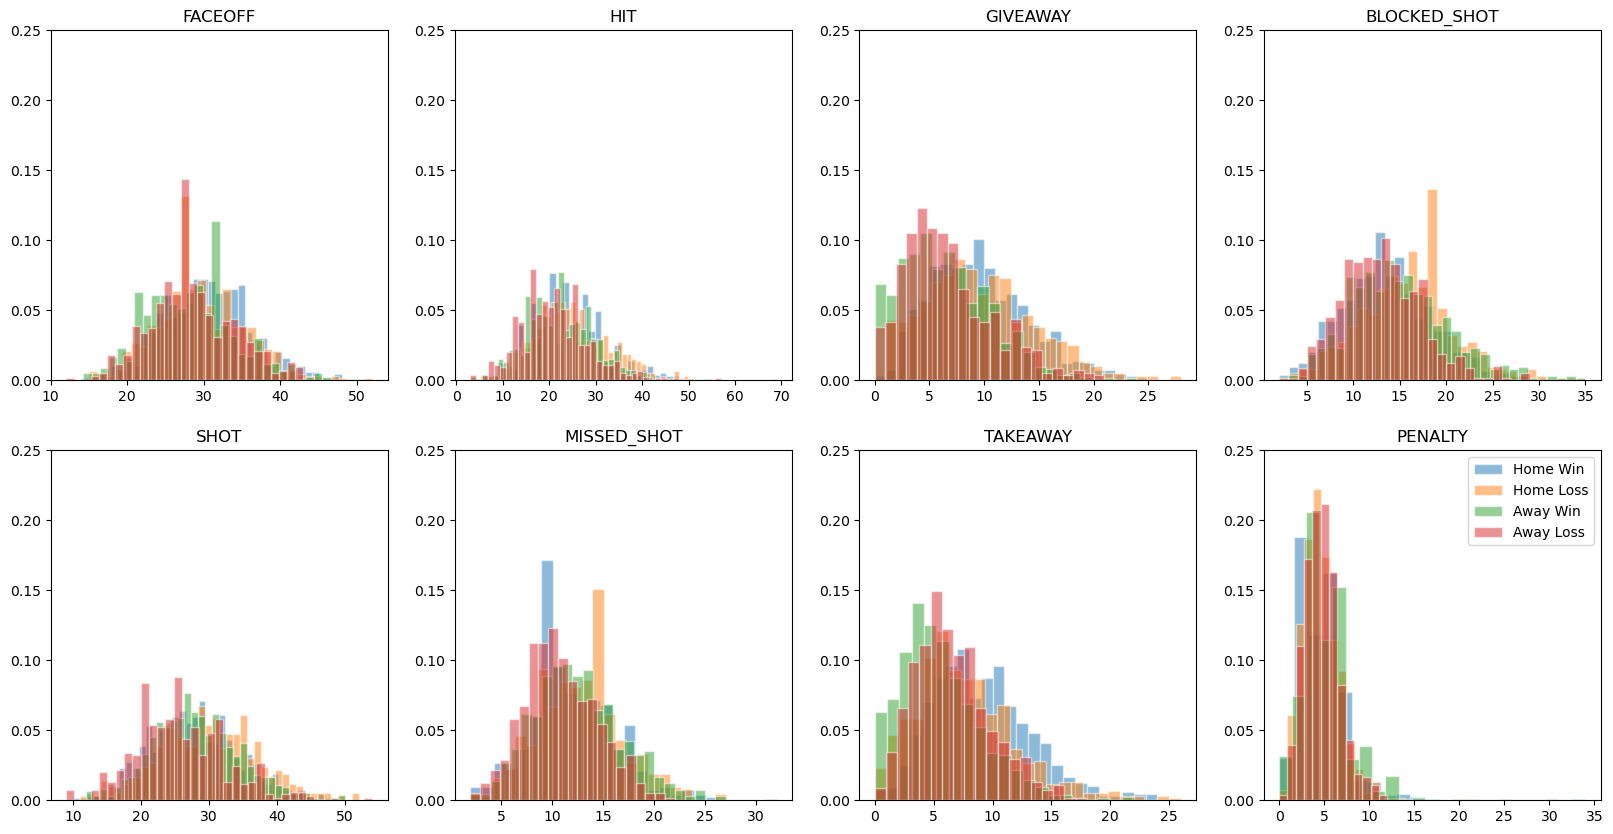

In [61]:
# Get the last rows for each game.
last_row = final_df_opt['GAME_ID'].shift(-1) != final_df_opt['GAME_ID']
last_row = final_df_opt.loc[last_row, :]

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
row, co = 2, 4
r, c = 0, 0
for i, col in enumerate(['FACEOFF', 'HIT', 'GIVEAWAY', 'BLOCKED_SHOT', 'SHOT', 'MISSED_SHOT', 'TAKEAWAY', 'PENALTY']):
    mask = last_row['WIN'] == 1
    ax[r, c].hist(last_row[mask][f'HOME_{col}'], alpha=0.5, bins=len(last_row[mask][f'HOME_{col}'].unique()), label='Home Win', density=True   , edgecolor='white')
    ax[r, c].hist(last_row[~mask][f'HOME_{col}'], alpha=0.5, bins=len(last_row[~mask][f'HOME_{col}'].unique()), label='Home Loss', density=True, edgecolor='white')
    ax[r, c].hist(last_row[mask][f'AWAY_{col}'], alpha=0.5, bins=len(last_row[mask][f'AWAY_{col}'].unique()), label='Away Win', density=True   , edgecolor='white')
    ax[r, c].hist(last_row[~mask][f'AWAY_{col}'], alpha=0.5, bins=len(last_row[~mask][f'AWAY_{col}'].unique()), label='Away Loss', density=True, edgecolor='white')
    ax[r, c].set_ylim(0, .25)
    ax[r, c].set_title(col)
    
    c += 1
    if c == co:
        c = 0
        r += 1

ax[r-1, c-1].legend()

plt.show()

In [9]:
f_df = final_df.fillna(0).copy()

# Get the game_ids
game_ids = f_df.GAME_ID.unique()
selected = np.random.choice(game_ids, 10)
f_df = f_df[f_df.GAME_ID.isin(selected)]

,HOME_FACEOFF,HOME_HIT,HOME_GIVEAWAY,HOME_BLOCKED_SHOT,HOME_SHOT,HOME_MISSED_SHOT,HOME_GOAL,HOME_TAKEAWAY,HOME_PENALTY,HOME_TIME_REMAINING,...,AWAY_GAME_ID,AWAY_CORSI,AWAY_FENWICK,TIME_REMAINING,WIN,GAME_ID,AWAY_CORSI_FOR,AWAY_FENWICK_FOR,HOME_CORSI_FOR,HOME_FENWICK_FOR
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3600.0,0.0,2.010020e+09,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,3572.0,0.0,2.010020e+09,1.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,3571.0,0.0,2.010020e+09,1.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,3559.0,0.0,2.010020e+09,1.000000,1.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,3528.0,0.0,2.010020e+09,1.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,27.0,18.0,10.0,13.0,29.0,10.0,4.0,6.0,5.0,0.0,...,0.0,58.0,37.0,82.0,1.0,2.010021e+09,0.527273,0.486842,0.472727,0.513158
244,27.0,18.0,10.0,13.0,29.0,10.0,4.0,6.0,5.0,0.0,...,0.0,58.0,37.0,82.0,1.0,2.010021e+09,0.527273,0.486842,0.472727,0.513158
245,27.0,18.0,10.0,13.0,29.0,10.0,4.0,6.0,5.0,0.0,...,0.0,59.0,38.0,48.0,1.0,2.010021e+09,0.531532,0.493506,0.472727,0.513158
246,27.0,18.0,10.0,13.0,29.0,10.0,4.0,6.0,5.0,0.0,...,0.0,59.0,38.0,39.0,1.0,2.010021e+09,0.531532,0.493506,0.472727,0.513158


<h1>Try t-SNE and UMAP</h1>

/Users/dylanskinner/opt/anaconda3/envs/acme1/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/dylanskinner/opt/anaconda3/envs/acme1/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/Users/dylanskinner/opt/anaconda3/envs/acme1/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/Users/dylanskinner/opt/anaconda3/envs/acme1/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/dylanskinner/opt/anaconda3/envs/acme1/lib/python3.7/site-packages/

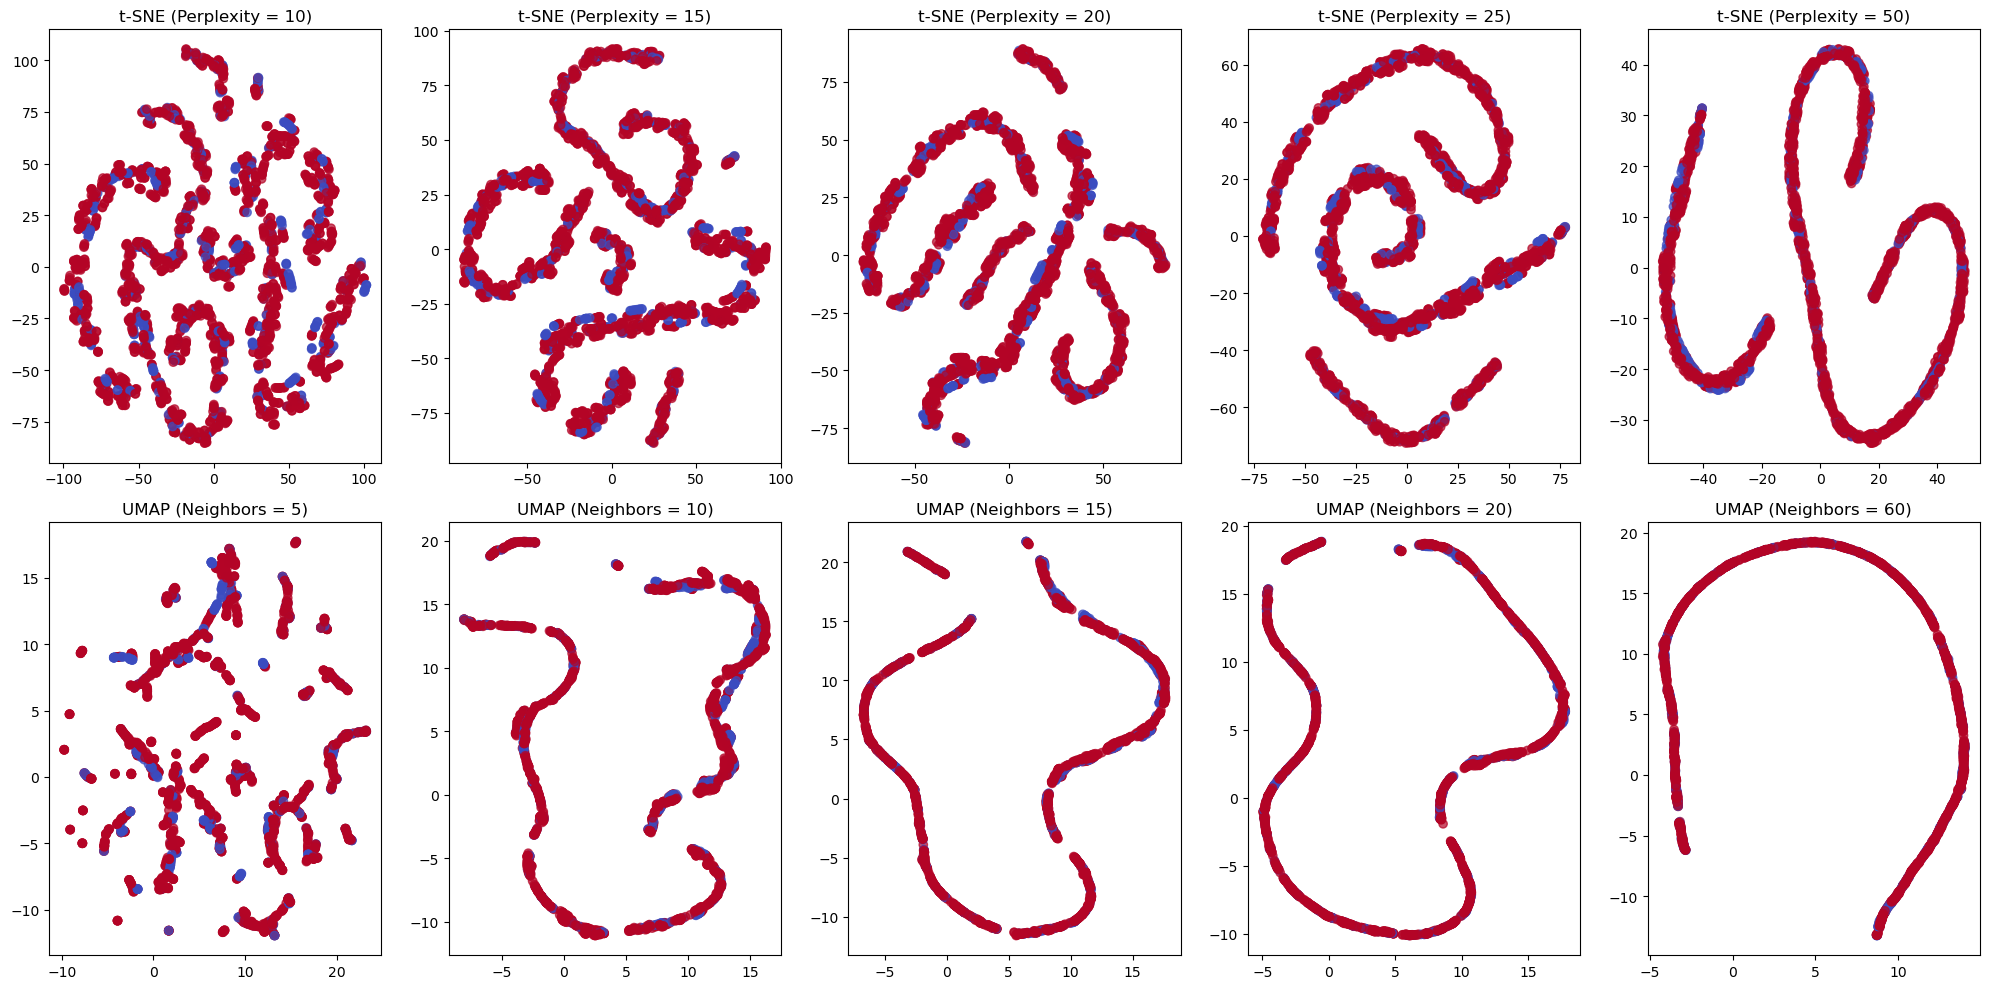

In [11]:
# Import t-SNE and UMAP
from sklearn.manifold import TSNE
from umap import UMAP

# Get the data
X = f_df.drop(columns=['WIN', 'GAME_ID'])
y = f_df.WIN

# Plot the results
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

for i, perp, neigh in zip(range(5), [10, 15, 20, 25, 50], [5, 10, 15, 20, 60]):
    # Initialize the models
    tsne = TSNE(n_components=2, perplexity=perp)
    umap = UMAP(n_components=2, n_neighbors=neigh)

    # Fit the models
    X_tsne = tsne.fit_transform(X)
    X_umap = umap.fit_transform(X)

    ax[0, i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.7)
    ax[0, i].set_title(f't-SNE (Perplexity = {perp})')
    ax[1, i].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='coolwarm', alpha=0.7)
    ax[1, i].set_title(f'UMAP (Neighbors = {neigh})')

plt.tight_layout()
plt.show()

[0 1]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


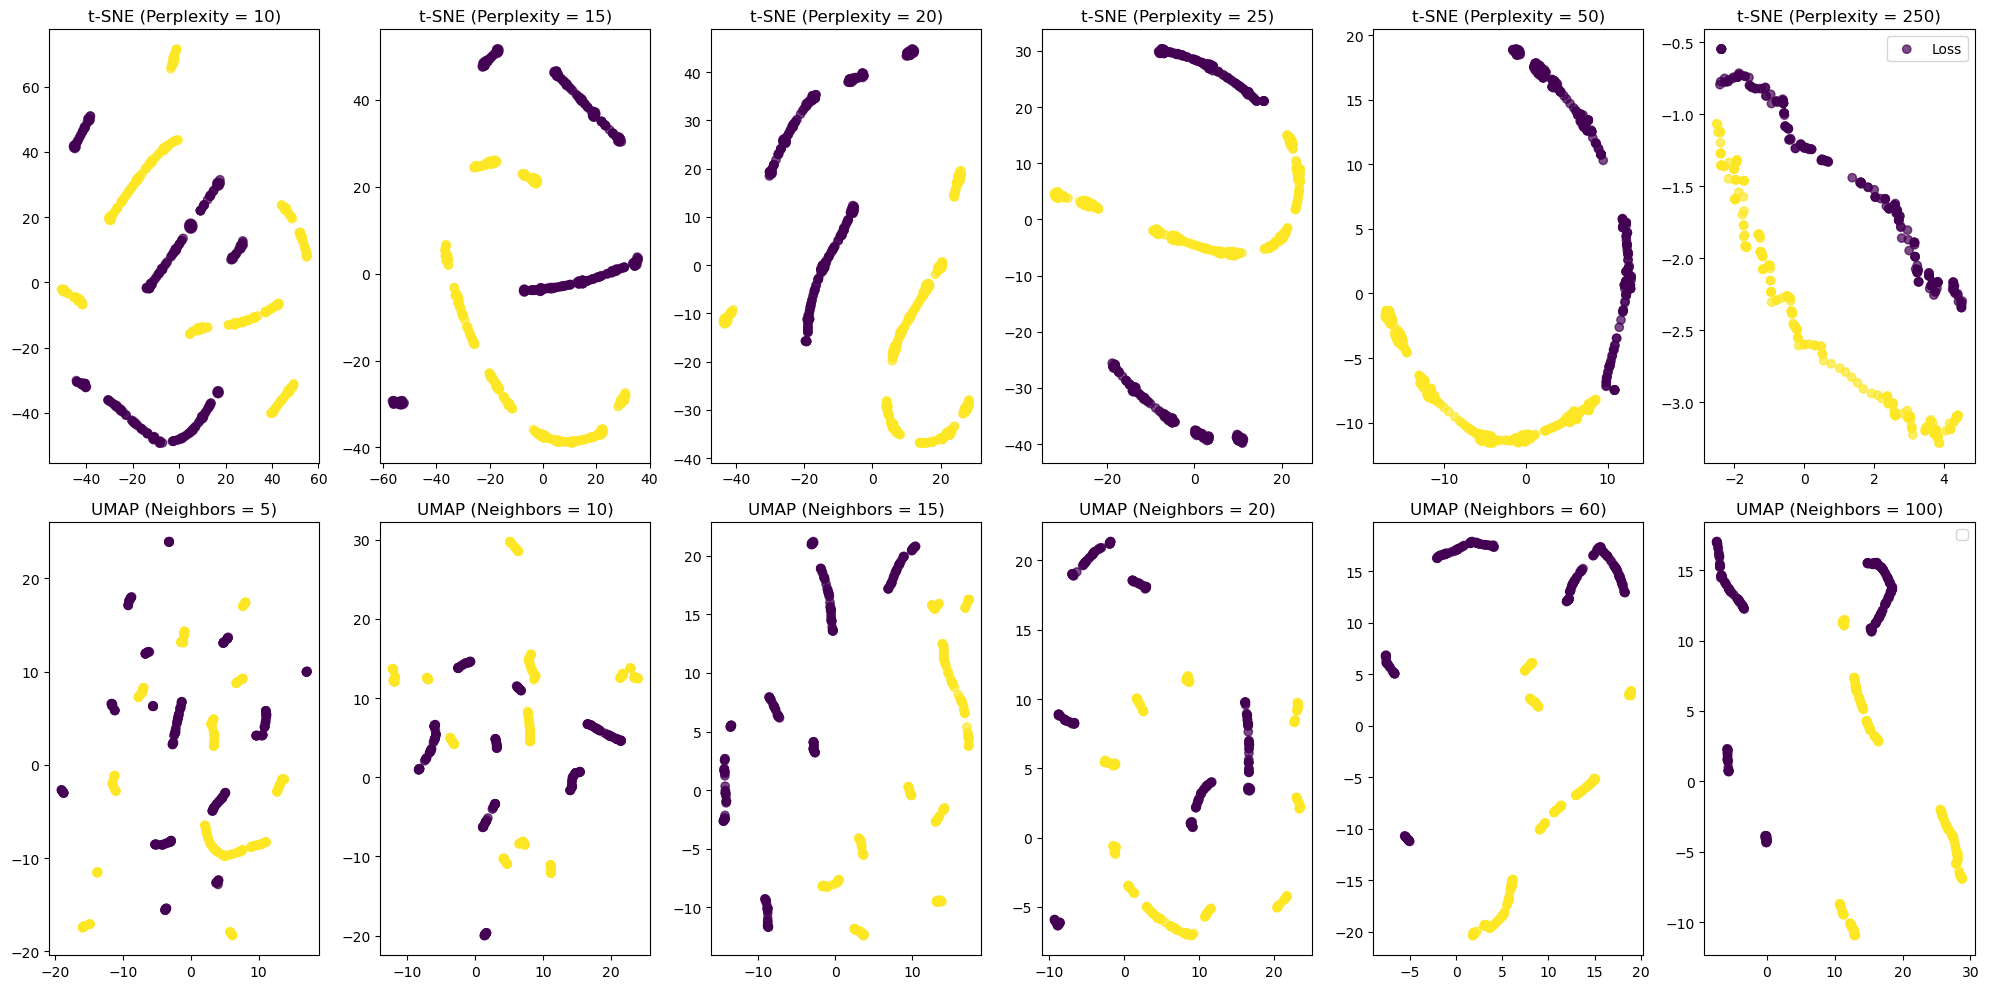

In [36]:
# Split f_df into home and away
test = f_df[f_df['GAME_ID'] == f_df.GAME_ID.unique()[0]]
test_home = test.filter(regex='HOME')
test_away = test.filter(regex='AWAY_')
test_home.columns = test_home.columns.str.replace('HOME_', '')
test_away.columns = test_away.columns.str.replace('AWAY_', '')
test_home['WIN'] = 0
test_away['WIN'] = 1

test = test_home.append(test_away).drop(columns='AWAY_HOME')

# Get the data
X = test.drop(columns=['WIN'])
y = test.WIN
print(y.unique())

# Plot the results
fig, ax = plt.subplots(2, 6, figsize=(20, 10))

for i, perp, neigh in zip(range(6), [10, 15, 20, 25, 50, 250], [5, 10, 15, 20, 60, 100]):
    # Initialize the models
    tsne = TSNE(n_components=2, perplexity=perp)
    umap = UMAP(n_components=2, n_neighbors=neigh)

    # Fit the models
    X_tsne = tsne.fit_transform(X)
    X_umap = umap.fit_transform(X)

    ax[0, i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
    ax[0, i].set_title(f't-SNE (Perplexity = {perp})')
    ax[1, i].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', alpha=0.7)
    ax[1, i].set_title(f'UMAP (Neighbors = {neigh})')
    
    # Add legend to the last plot
    if i == 5:
        ax[0, i].legend(['Loss', 'Win'], loc='upper right')
        ax[1, i].legend(['Loss', 'Win'], loc='upper right')

plt.legend()
plt.tight_layout()
plt.show()

In [35]:
test = f_df[f_df['GAME_ID'] == f_df.GAME_ID.unique()[0]]
test_home = test.filter(regex='HOME')
test_away = test.filter(regex='AWAY_')
test_home.columns = test_home.columns.str.replace('HOME_', '')
test_away.columns = test_away.columns.str.replace('AWAY_', '')
test_home['WIN'] = 0
test_away['WIN'] = 1

test = test_home.append(test_away).drop(columns='AWAY_HOME')
test

,FACEOFF,HIT,GIVEAWAY,BLOCKED_SHOT,SHOT,MISSED_SHOT,GOAL,TAKEAWAY,PENALTY,TIME_REMAINING,HOME,WIN,TEAM,GAME_ID,CORSI,FENWICK,CORSI_FOR,FENWICK_FOR
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,33.0,19.0,1.0,12.0,23.0,9.0,6.0,8.0,8.0,0.0,0.0,1,13.0,0.0,44.0,32.0,0.511628,0.477612
230,33.0,19.0,1.0,12.0,23.0,9.0,6.0,9.0,8.0,0.0,0.0,1,13.0,0.0,44.0,32.0,0.511628,0.477612
231,33.0,19.0,1.0,12.0,24.0,9.0,6.0,9.0,8.0,0.0,0.0,1,13.0,0.0,44.0,32.0,0.511628,0.477612
232,33.0,19.0,1.0,12.0,24.0,9.0,6.0,9.0,8.0,0.0,0.0,1,13.0,0.0,44.0,32.0,0.511628,0.477612


<h1>Compare Our Simulation Against the Real Data</h1>

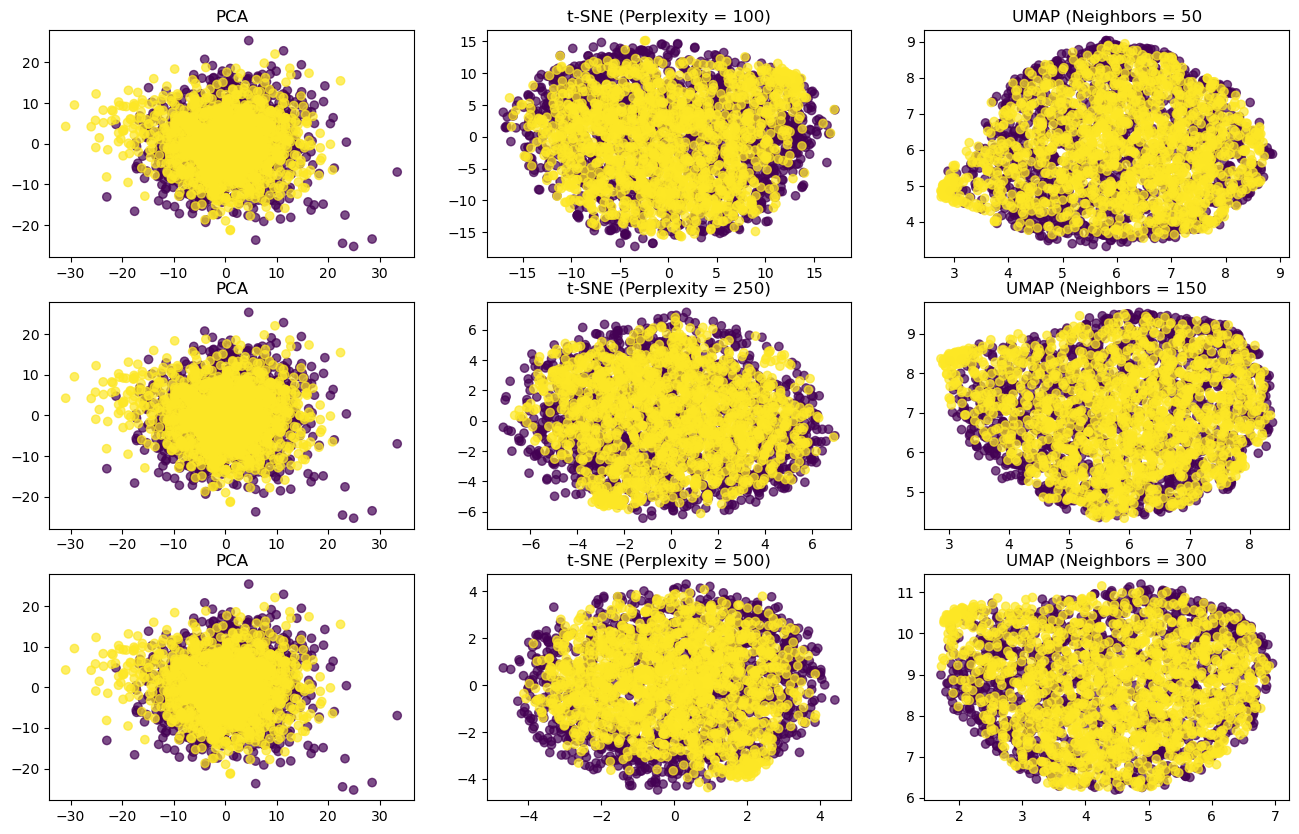

In [120]:
# Do t-SNE, UMAP, and PCA on the simulated data against the real data
# Simulated data
simulated = pd.read_feather('data/dylan_data/lasts.feather')
actual = last_row.copy()
actual.drop(columns=['TIME_REMAINING', 'WIN', 'GAME_ID', 'AWAY_CORSI_FOR',
       'AWAY_FENWICK_FOR', 'HOME_CORSI_FOR', 'HOME_FENWICK_FOR', 'AWAY_CORSI', 'AWAY_FENWICK',
       'AWAY_GAME_ID', 'AWAY_TIME_REMAINING', 'AWAY_WIN', 'HOME_CORSI',
       'HOME_FENWICK', 'HOME_GAME_ID', 'HOME_HIT', 'AWAY_HIT',
       'HOME_TEAM', 'HOME_TIME_REMAINING', 'HOME_WIN', 'AWAY_HOME','AWAY_TEAM', 'HOME_HOME',
       ], inplace=True)

simulated.drop(columns=['time_remaining', 'home_score', 'away_score', 'game_id', 'BLOCKED_SHOT_-'], inplace=True)
actual = actual[actual.columns.sort_values()]
simulated = simulated[simulated.columns.sort_values()]
simulated.columns = [f'{col[-1]}_{"_".join(col[:-1])}' for col in simulated.columns.str.split('_')]
simulated = simulated[simulated.columns.sort_values()]

# Assign labels
actual['simulated'] = 0
simulated['simulated'] = 1

vals = actual.append(simulated)
X, y = vals.drop(columns=['simulated']), vals.simulated

# Fill all NaN's with 0
X.fillna(0, inplace=True)

# Perform PCA, t-SNE, and UMAP on the data
X_pca = PCA(n_components=2).fit_transform(X)

fig, ax = plt.subplots(3,3, figsize=(16, 10))
i = 0
for perp, neigh in [[100, 50], [250, 150], [500, 300]]:
       # Compute t-SNE
       X_tsne = TSNE(n_components=2, perplexity=perp).fit_transform(X)
       
       # Compute UMAP
       X_umap = UMAP(n_components=2, n_neighbors=neigh).fit_transform(X)
       
       # Plot the results
       ax[i, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
       ax[i, 0].set_title('PCA')
       
       ax[i, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
       ax[i, 1].set_title(f't-SNE (Perplexity = {perp})')
       
       ax[i, 2].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', alpha=0.7)
       ax[i, 2].set_title(f'UMAP (Neighbors = {neigh}')
       
       i += 1
       

In [115]:
# Get all rows that contain a NaN value
nan_rows = X[X.isna().any(axis=1)]
nan_rows

,AWAY_BLOCKED_SHOT,AWAY_FACEOFF,AWAY_GIVEAWAY,AWAY_GOAL,AWAY_MISSED_SHOT,AWAY_PENALTY,AWAY_SHOT,AWAY_TAKEAWAY,HOME_BLOCKED_SHOT,HOME_FACEOFF,HOME_GIVEAWAY,HOME_GOAL,HOME_MISSED_SHOT,HOME_PENALTY,HOME_SHOT,HOME_TAKEAWAY
251,17.0,26.0,11.0,0.0,6.0,NaN,24.0,4.0,17.0,35.0,7.0,1.0,18.0,NaN,37.0,3.0
